# Atreyus.AI Machine Learning Project
## CIFAR-10 Image Classifier using PyTorch and Streamlit

In this notebook, I will be showcasing my ability to complete a ML workflow from concept to product as required. In this project, I will be utilizing the CIFAR-1O dataset to conduct an image classification task by using a simple 4-6 layer *Convolutional Neural Network (CNN)*. We will evaluate this by demonstrating its accuracy, confusion matrix and per-class accuracy. Also, to demonstrate my ability to be hired for the Data Science / Machine Learning Intern role, I will also use saliency maps for explainability as well as an interactive streamlit app. Throughout this notebook, I will explain each step as I go and also summarize my findings in a PowerPoint. 

Now, let us get started! 

### Step 1) **Load the Dataset**

We begin by loading the `trainLabels.csv` file, which maps image IDs to their respective CIFAR-10 class labels. Notice that we need to correctly use our path correctly otherwise the code will not work. 

In [27]:
import pandas as pd
import os

# Set path to actual image folder
image_dir = "CIFAR10 Dataset/train/train"
csv_path = "CIFAR10 Dataset/trainLabels.csv"

# Load and clean CSV
labels_df = pd.read_csv(csv_path, dtype={'id': str})
labels_df['id'] = labels_df['id'].apply(lambda x: f"{x}.png" if not x.endswith(".png") else x)

# Filter to only valid images that exist
available_images = set(os.listdir(image_dir))
labels_df = labels_df[labels_df['id'].isin(available_images)].reset_index(drop=True)

print("Filtered label count:", len(labels_df))

Filtered label count: 50000


### **Step 2) Define Preprocessing**

Before we can feed any images into our Convolutional Neural Network (CNN), we need to preprocess them to ensure uniformity and compatibility. In the CIFAR-10 Dataset, the CIFAR-10 Images are originally 32x32 pixels, so we explicity resize and normalize them. *Normalization* ensures that pixel intensities are centered around 0, which speeds up training. 

### **Step 3) Define Custom Dataset Class**

To load our data into PyTorch, we define a custom `Dataset` class that extends `torch.utils.data.Dataset`. This allows us to map image file names to their label and apply transformations on-the-fly. This is essential for batch loading and GPU-accelerated training.

In [ ]:
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

# Define preprocessing (Step 2)
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Custom dataset class (Step 3)
class CIFAR10Dataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.classes = sorted(df['label'].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['id']
        label_name = self.df.iloc[idx]['label']
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        label = self.class_to_idx[label_name]

        if self.transform:
            image = self.transform(image)

        return image, label

### **Step 4) Ininitialize Dataloader**

We use PyTorch’s `DataLoader` to enable shuffling and batching of images during training. This improves generalization and speeds up training by utilizing mini-batches rather than loading one image at a time.

In [29]:
from torch.utils.data import DataLoader

dataset = CIFAR10Dataset(df=labels_df, img_dir=image_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

print("Dataset size:", len(dataset))

Dataset size: 50000


### **Step 5) Show Sample Batch**

Before training, it is important to visually confirm that the dataset was loaded correctly. Here, we display the first few images from the DataLoader along with their corresponding labels.

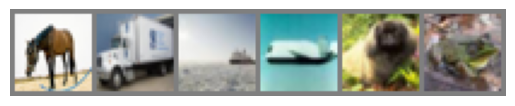

Labels: horse | truck | ship | airplane | dog | frog


In [30]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Display a few samples
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:6]))
print('Labels:', ' | '.join([dataset.classes[label] for label in labels[:6]]))


### **6) Define the CNN Model** 

We implement a simple CNN architecture with two convolutional layers followed by two fully connected (dense) layers. Dropout is used to reduce overfitting, and ReLU activation is applied after each layer. The model ends in a softmax-like output layer for classification into 10 classes.

In [31]:
# Build a Custom CNN for CIFAR-10

import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Reduces 32x32 → 16x16 → 8x8
        self.dropout = nn.Dropout(0.25)

        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x32 → 16x16
        x = self.pool(F.relu(self.conv2(x)))  # 16x16 → 8x8
        x = x.view(-1, 64 * 8 * 8)            # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
# Step 6: Train the Model (cont.'d.)
# Set up the training components

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN(num_classes=len(dataset.classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### **7) Training Loop**

We train the CNN using the Adam optimizer and cross-entropy loss for classification. Each epoch consists of forward passes, backpropagation, and parameter updates. Accuracy is computed per epoch to track performance.

In [33]:
# Training Loop (Step 7)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Stats
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f} - Accuracy: {100*correct/total:.2f}%")

Epoch 1/5 - Loss: 2065.7227 - Accuracy: 52.40%
Epoch 2/5 - Loss: 1467.5084 - Accuracy: 66.85%
Epoch 3/5 - Loss: 1197.0192 - Accuracy: 72.97%
Epoch 4/5 - Loss: 971.6842 - Accuracy: 78.22%
Epoch 5/5 - Loss: 785.5963 - Accuracy: 82.26%


### **Step 8) Evaluate Model with Predictions** 

Once training is complete, we use the trained model to make predictions on unseen test images. The model outputs class probabilities and we display the top-3 most likely predictions along with confidence scores.

In [34]:
# Step 8 Run Predictions on Test Images 
# 8.1 Define Dataset for Test Images (No Labels)

class UnlabeledImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.image_files = sorted(os.listdir(img_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, img_name


In [35]:
# 8.2 Create DataLoader for Test Images

test_img_dir = "CIFAR10 Dataset/test/test"
test_dataset = UnlabeledImageDataset(img_dir=test_img_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [36]:
# Predict and Display Top Class

model.eval()

with torch.no_grad():
    for images, filenames in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        class_name = dataset.classes[predicted.item()]

        print(f"{filenames[0]} → {class_name}")
        break  # remove this to print more than one


1.png → deer


### **Step 9) Visualize the Model with Predictions** 

Let us also see what it does visually. 

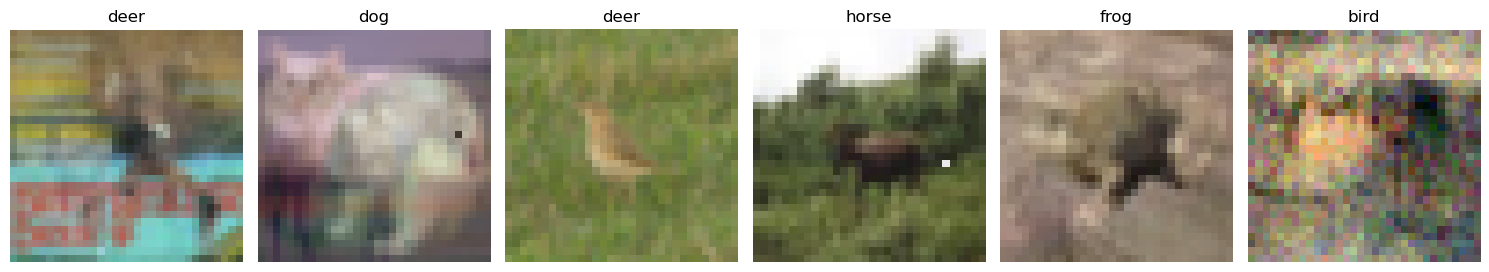

In [37]:
# Step 9 Visualize Predictions on Test Images 
# 9.1 Display a Grid of Predicted Images

import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Get a few test images
num_images = 6
fig, axs = plt.subplots(1, num_images, figsize=(15, 3))

with torch.no_grad():
    for i, (image, filename) in enumerate(test_loader):
        if i >= num_images:
            break

        image = image.to(device)
        output = model(image)
        _, pred = torch.max(output, 1)
        pred_class = dataset.classes[pred.item()]

        # Convert tensor to displayable image
        img_np = image.cpu().squeeze().permute(1, 2, 0).numpy()
        img_np = (img_np * 0.5) + 0.5  # unnormalize

        axs[i].imshow(img_np)
        axs[i].set_title(pred_class)
        axs[i].axis('off')

plt.tight_layout()
plt.show()


In [38]:
# Step 10 Show Top-3 Predictions + Confidence

import torch.nn.functional as F

# Show top-3 predictions for a few test images
model.eval()
num_images = 5

with torch.no_grad():
    for i, (image, filename) in enumerate(test_loader):
        if i >= num_images:
            break

        image = image.to(device)
        output = model(image)
        probabilities = F.softmax(output, dim=1)

        top_probs, top_idxs = torch.topk(probabilities, 3)
        top_probs = top_probs.squeeze().cpu().numpy()
        top_idxs = top_idxs.squeeze().cpu().numpy()

        print(f"Filename: {filename[0]}")
        for j in range(3):
            label = dataset.classes[top_idxs[j]]
            prob = top_probs[j] * 100
            print(f"  {j+1}. {label}: {prob:.2f}%")
        print("-" * 30)


Filename: 1.png
  1. deer: 77.51%
  2. cat: 10.43%
  3. dog: 6.21%
------------------------------
Filename: 10.png
  1. dog: 55.73%
  2. cat: 35.86%
  3. horse: 3.17%
------------------------------
Filename: 100.png
  1. deer: 84.86%
  2. bird: 14.72%
  3. frog: 0.38%
------------------------------
Filename: 1000.png
  1. horse: 55.41%
  2. deer: 17.70%
  3. bird: 17.30%
------------------------------
Filename: 10000.png
  1. frog: 40.38%
  2. deer: 31.09%
  3. cat: 18.22%
------------------------------


### **Step 10) Saving Our Model** 

Below we save our model so the user does not need to utilize our notebook for our classifier. 

In [39]:
torch.save(model.state_dict(), "cifar10_cnn.pth")

### **Step 11) Implement an Interactive Element**

After training and evaluating the model, we deploy it using [Streamlit](https://streamlit.io), a Python-based framework for building interactive web apps.

In our `streamlit_app.py`, we:

- Load the trained CNN model (`cifar10_cnn.pth`)
- Define the same preprocessing pipeline used during training
- Provide a file uploader so users can submit their own images
- Display top-3 predictions with confidence percentages
- Format everything into a clean UI with a sidebar and real-time feedback

This allows anyone to interact with the classifier — no Jupyter environment required — turning a research prototype into an accessible demo.

> The goal is to bridge model development with practical usage in a user-friendly interface.


**View the App Script**  
See `streamlit_app.py` for the complete deployment implementation.